# Explore here

SVM: Spam link detection system

Step 1: Loading the dataset

In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv"

total_data = pd.read_csv(url)
print(total_data.head())


                                                 url  is_spam
0  https://briefingday.us8.list-manage.com/unsubs...     True
1                             https://www.hvper.com/     True
2                 https://briefingday.com/m/v4n3i4f3     True
3   https://briefingday.com/n/20200618/m#commentform    False
4                        https://briefingday.com/fan     True


Step 2: Preprocess the links

Categorical to numerical transformation

In [2]:
total_data["is_spam"] = total_data["is_spam"].apply(lambda x: 1 if x else 0).astype(int)
total_data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


Elimination of repeated values

In [3]:
print(total_data.shape)
total_data = total_data.drop_duplicates()
total_data = total_data.reset_index(inplace = False, drop = True)
total_data.shape

(2999, 2)


(2369, 2)

In [4]:
print(f"Spam: {len(total_data.loc[total_data.is_spam == 1])}")
print(f"No spam: {len(total_data.loc[total_data.is_spam == 0])}")

Spam: 244
No spam: 2125


Text processing

In [6]:
import regex as re

def preprocess_text(text):
    # Remove any character that is not a letter (a-z) or white space ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Remove white spaces
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Multiple white spaces into one
    text = re.sub(r'\s+', " ", text.lower())

    # Remove tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

total_data["url"] = total_data["url"].apply(preprocess_text)
total_data.head()

,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",1
1,"[https, www, hvper, com]",1
2,"[https, briefingday, com, v, i]",1
3,"[https, briefingday, com, m, commentform]",0
4,"[https, briefingday, com, fan]",1


In [8]:
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

total_data["url"] = total_data["url"].apply(lemmatize_text)
total_data.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mariannacastro/nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mariannacastro/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,url,is_spam
0,"[http, briefingday, list, manage, unsubscribe]",1
1,"[http, hvper]",1
2,"[http, briefingday]",1
3,"[http, briefingday, commentform]",0
4,"[http, briefingday]",1


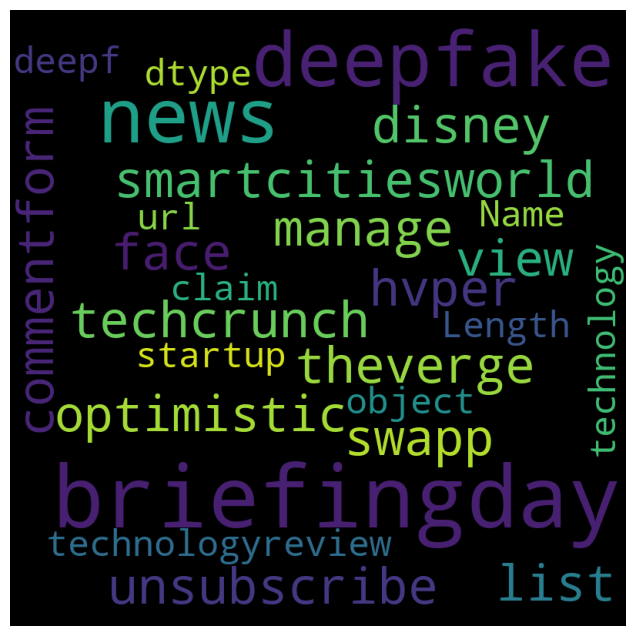

In [11]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(total_data["url"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokens_list = total_data["url"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = total_data["is_spam"]

X[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(5, 538))

In [14]:
# Create a copy to export
export_data = total_data.copy()

# Join the tokens back into a single string for each URL (e.g., for JSON readability)
export_data["url"] = export_data["url"].apply(lambda x: " ".join(x))

# Save to JSON
export_data.to_json("preprocessed_url_spam_dataset.json", orient="records", lines=True)

print("✅ Dataset saved as preprocessed_url_spam_dataset.json")


✅ Dataset saved as preprocessed_url_spam_dataset.json


In [15]:
{"url": "http briefingday list manage unsubscribe", "is_spam": 1}
{"url": "http hvper", "is_spam": 1}
{"url": "http briefingday", "is_spam": 1}
...


Ellipsis

In [16]:
import numpy as np
import json

# Creamos copia de los datos
X_con_outliers = X.copy()
X_sin_outliers = X.copy()

outliers_dict = {}

# Iterar por cada columna (o sea, cada palabra)
for idx, word in enumerate(vectorizer.get_feature_names_out()):
    column = X_sin_outliers[:, idx]
    q1 = np.percentile(column, 25)
    q3 = np.percentile(column, 75)
    iqr = q3 - q1
    lower = max(0, q1 - 1.5 * iqr)
    upper = q3 + 1.5 * iqr

    # Limitar valores
    column = np.clip(column, lower, upper)
    X_sin_outliers[:, idx] = column

    # Guardamos los límites
    outliers_dict[word] = [lower, upper]

# Guardar el diccionario
with open("outliers_replacement.json", "w") as f:
    json.dump(outliers_dict, f)

print("✅ Diccionario de outliers guardado como outliers_replacement.json")


✅ Diccionario de outliers guardado como outliers_replacement.json


In [20]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Asegúrate de tener X (matriz TF-IDF) y y (etiquetas) generados previamente

# ⚠️ CAMBIA ESTA RUTA según tu carpeta local "processed"
output_path = "/Users/mariannacastro/Desktop/4Geeks/proyectos/NLP-Project-Tutorial-Mari/data/processed"
os.makedirs(output_path, exist_ok=True)

# Split de datos
X_train_con_outliers, X_test_con_outliers, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Copias para la versión "sin outliers"
X_train_sin_outliers = X_train_con_outliers.copy()
X_test_sin_outliers = X_test_con_outliers.copy()

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_con_outliers)
X_test_scaled = scaler.transform(X_test_con_outliers)

# Convertimos a DataFrame (usando nombres de palabras del vectorizador)
X_train_df = pd.DataFrame(X_train_scaled, columns=vectorizer.get_feature_names_out())
X_test_df = pd.DataFrame(X_test_scaled, columns=vectorizer.get_feature_names_out())
y_train_df = pd.DataFrame(y_train.values, columns=["is_spam"])
y_test_df = pd.DataFrame(y_test.values, columns=["is_spam"])

# Guardar los archivos Excel
X_train_df.to_excel(os.path.join(output_path, "X_train_scaled.xlsx"), index=False)
X_test_df.to_excel(os.path.join(output_path, "X_test_scaled.xlsx"), index=False)
y_train_df.to_excel(os.path.join(output_path, "y_train.xlsx"), index=False)
y_test_df.to_excel(os.path.join(output_path, "y_test.xlsx"), index=False)

print("✅ Archivos escalados y guardados correctamente en la carpeta 'processed'.")


✅ Archivos escalados y guardados correctamente en la carpeta 'processed'.


In [21]:
import os
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# ⚠️ CAMBIA estas rutas a las que estés usando en tu máquina
data_output_path = "/Users/mariannacastro/Desktop/4Geeks/proyectos/NLP-Project-Tutorial-Mari/data/processed"
model_output_path = "/Users/mariannacastro/Desktop/4Geeks/proyectos/NLP-Project-Tutorial-Mari/models"
os.makedirs(data_output_path, exist_ok=True)
os.makedirs(model_output_path, exist_ok=True)

# === NORMALIZACIÓN ===
# CON OUTLIERS
normalizador_con = StandardScaler()
X_train_norm_con = normalizador_con.fit_transform(X_train_con_outliers)
X_test_norm_con = normalizador_con.transform(X_test_con_outliers)

# Guardar el normalizador
with open(os.path.join(model_output_path, "normalizador_con_outliers.pkl"), "wb") as f:
    pickle.dump(normalizador_con, f)

# SIN OUTLIERS
normalizador_sin = StandardScaler()
X_train_norm_sin = normalizador_sin.fit_transform(X_train_sin_outliers)
X_test_norm_sin = normalizador_sin.transform(X_test_sin_outliers)

# Guardar el normalizador
with open(os.path.join(model_output_path, "normalizador_sin_outliers.pkl"), "wb") as f:
    pickle.dump(normalizador_sin, f)

# Guardar los datasets normalizados
pd.DataFrame(X_train_norm_con, columns=vectorizer.get_feature_names_out()).to_excel(os.path.join(data_output_path, "X_train_con_outliers_norm.xlsx"), index=False)
pd.DataFrame(X_test_norm_con, columns=vectorizer.get_feature_names_out()).to_excel(os.path.join(data_output_path, "X_test_con_outliers_norm.xlsx"), index=False)

pd.DataFrame(X_train_norm_sin, columns=vectorizer.get_feature_names_out()).to_excel(os.path.join(data_output_path, "X_train_sin_outliers_norm.xlsx"), index=False)
pd.DataFrame(X_test_norm_sin, columns=vectorizer.get_feature_names_out()).to_excel(os.path.join(data_output_path, "X_test_sin_outliers_norm.xlsx"), index=False)

print("✅ Normalización completa y guardada")

# === MIN-MAX SCALING ===
# CON OUTLIERS
scaler_con = MinMaxScaler()
X_train_scal_con = scaler_con.fit_transform(X_train_con_outliers)
X_test_scal_con = scaler_con.transform(X_test_con_outliers)

# Guardar el scaler
with open(os.path.join(model_output_path, "scaler_con_outliers.pkl"), "wb") as f:
    pickle.dump(scaler_con, f)

# SIN OUTLIERS
scaler_sin = MinMaxScaler()
X_train_scal_sin = scaler_sin.fit_transform(X_train_sin_outliers)
X_test_scal_sin = scaler_sin.transform(X_test_sin_outliers)

# Guardar el scaler
with open(os.path.join(model_output_path, "scaler_sin_outliers.pkl"), "wb") as f:
    pickle.dump(scaler_sin, f)

# Guardar los datasets escalados
pd.DataFrame(X_train_scal_con, columns=vectorizer.get_feature_names_out()).to_excel(os.path.join(data_output_path, "X_train_con_outliers_scal.xlsx"), index=False)
pd.DataFrame(X_test_scal_con, columns=vectorizer.get_feature_names_out()).to_excel(os.path.join(data_output_path, "X_test_con_outliers_scal.xlsx"), index=False)

pd.DataFrame(X_train_scal_sin, columns=vectorizer.get_feature_names_out()).to_excel(os.path.join(data_output_path, "X_train_sin_outliers_scal.xlsx"), index=False)
pd.DataFrame(X_test_scal_sin, columns=vectorizer.get_feature_names_out()).to_excel(os.path.join(data_output_path, "X_test_sin_outliers_scal.xlsx"), index=False)

print("✅ Min-Max scaling completo y guardado")


✅ Normalización completa y guardada
✅ Min-Max scaling completo y guardado


Train test split

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Step 3: Build an SVM

In [23]:
from sklearn.svm import SVC

model = SVC(kernel = "linear", random_state = 42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [24]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [25]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9514767932489452

Step 4: Optimize the previous model

In [26]:
import numpy as np
from sklearn.model_selection import GridSearchCV

hyperparams = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "kernel": ["linear", "poly", "rbf", "sigmoid", "precomputed’"],
    "degree": [1, 2, 3, 4, 5],
    "gamma": ["scale", "auto"]
}

# We initialize the random search
grid = GridSearchCV(model, hyperparams, scoring = "accuracy", cv = 5)
grid

GridSearchCV(cv=5, estimator=SVC(kernel='linear', random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'degree': [1, 2, 3, 4, 5], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid',
                                    'precomputed’']},
             scoring='accuracy')

In [27]:
grid.fit(X_train, y_train)

print(f"Best hyperparameters: {grid.best_params_}")

Best hyperparameters: {'C': 1000, 'degree': 1, 'gamma': 'auto', 'kernel': 'poly'}


/Users/mariannacastro/Desktop/4Geeks/proyectos/NLP-Project-Tutorial-Mari/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
350 fits failed out of a total of 1750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
350 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mariannacastro/Desktop/4Geeks/proyectos/NLP-Project-Tutorial-Mari/venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/mariannacastro/Desktop/4Geeks/proyectos/NLP-Project-Tutorial-Mari/venv/lib/python3.13/site-packages/sklearn/base.

In [28]:
opt_model = SVC(C = 1000, degree = 1, gamma = "auto", kernel = "poly", random_state = 42)
opt_model.fit(X_train, y_train)
y_pred = opt_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9620253164556962

Step 5: Save the model

In [30]:
import os
from pickle import dump

# ✅ Ruta real donde quieres guardar tu modelo
model_path = "/Users/mariannacastro/Desktop/4Geeks/proyectos/NLP-Project-Tutorial-Mari/models"
os.makedirs(model_path, exist_ok=True)  # Crea la carpeta si no existe

# ✅ Nombre del archivo
model_filename = "svm_classifier_C-1000_deg-1_gam-auto_ker-poly_42.sav"

# ✅ Guardar el modelo
with open(os.path.join(model_path, model_filename), "wb") as file:
    dump(model, file)

print(f"✅ Modelo guardado correctamente en: {os.path.join(model_path, model_filename)}")


✅ Modelo guardado correctamente en: /Users/mariannacastro/Desktop/4Geeks/proyectos/NLP-Project-Tutorial-Mari/models/svm_classifier_C-1000_deg-1_gam-auto_ker-poly_42.sav
